In [1]:
import os

os.chdir("../")

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import timm
import numpy as np

import argparse
import torch_optimizer as optimizer
import wandb

from config import settings

import models.spinalnet_resnet as spinalnet_resnet
import models.effnet as effnet
import models.densenet as densenet
import models.spinalnet_vgg as spinalnet_vgg
import models.vitL16 as vitL16
import models.alexnet_vgg as alexnet_vgg
import models.resnet18 as resnet18

import  data
# import data.segmentation as segmentation
# import metrics.metrics as metrics
from data import DataPart
from train import Trainer
import metrics


all_models = [
    ('ResNet18', resnet18.load_model()),
    ('EfficientNet', effnet.load_model()),
    ('DenseNet', densenet.load_model()),
    ('SpinalNet_ResNet', spinalnet_resnet.load_model()),
    ('SpinalNet_VGG', spinalnet_vgg.load_model()),
    ('ViTL16', vitL16.load_model()),
    ('AlexNet_VGG', alexnet_vgg.load_model())
]

all_optimizers = [
    ('SGD', optim.SGD),
    ('Rprop', optim.Rprop),
    ('Adam', optim.Adam),
    ('NAdam', optim.NAdam),
    ('RAdam', optim.RAdam),
    ('AdamW', optim.AdamW),
    #('Adagrad', optim.Adagrad),
    ('RMSprop', optim.RMSprop),
    #('Adadelta', optim.Adadelta),
    ('DiffGrad', optimizer.DiffGrad),
    # ('LBFGS', optim.LBFGS)
]

In [3]:
-float("inf") > 0

False

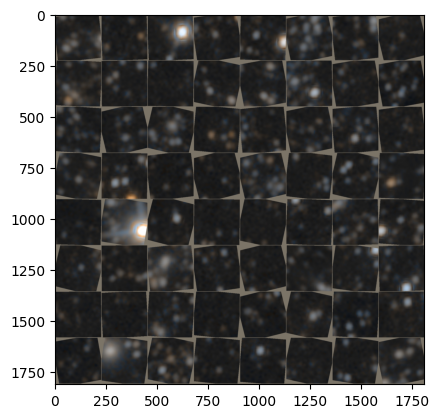

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, dataloaders = data.create_dataloaders()

train_loader = dataloaders[DataPart.TRAIN]
val_loader = dataloaders[DataPart.VALIDATE]
test_loader = dataloaders[DataPart.TEST_DR5]


In [3]:

# parser = argparse.ArgumentParser(description='Model training')
# parser.add_argument('--models', nargs='+', default=['ResNet18', 'EfficientNet', 'DenseNet', 'SpinalNet_ResNet', 'SpinalNet_VGG', 'ViTL16', 'AlexNet_VGG'],
#                     help='List of models to train (default: all)')
# parser.add_argument('--epochs', type=int, default=5, help='Number of epochs to train (default: 5)')
# parser.add_argument('--lr', type=float, default=0.0001, help='Learning rate for optimizer (default: 0.0001)')
# parser.add_argument('--mm', type=float, default=0.9, help='Momentum for optimizer (default: 0.9)')
# parser.add_argument('--optimizer', choices=[name for name, _ in all_optimizers], default='Adam', help='Optimizer to use (default: Adam)')

# args = parser.parse_args()

# selected_models = [(model_name, model) for model_name, model in models if model_name in args.models]

# num_epochs = args.epochs
# lr = args.lr
# momentum = args.mm
# optimizer_name = args.optimizer


In [4]:
selected_models = all_models[:2]

num_epochs = 1
lr = 0.0001
momentum = 0.9
optimizer_name = "Adam"




In [5]:
if settings.wandb_api_token:
    wandb.login(key=settings.wandb_api_token)
    wandb.init(project='cluster-search', config={}, reinit=True)
else:
    wandb.init(project='cluster-search', config={}, reinit=True)


wandb.config.models = [name for name, _ in selected_models]
wandb.config.num_epochs = num_epochs
wandb.config.lr = lr
wandb.config.momentum = momentum
wandb.config.optimizer = optimizer_name

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zehov1 (mzekhov). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/mszekhov/.netrc


In [6]:

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

results = {}
val_results = {}

classes = ('random', 'clusters')


In [7]:
for model_name, model in selected_models:
     optimizer_class = dict(all_optimizers)[optimizer_name]

     if optimizer_name in ['SGD', 'RMSprop']:
          optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum) 
     else:
          optimizer = optimizer_class(model.parameters(), lr=lr)
         
     trainer = Trainer(
          model=model,
          criterion=criterion,
          optimizer=optimizer,
          train_dataloader=train_loader,
          val_dataloader=val_loader,

     )

     trainer.train(num_epochs)

     for step in range(trainer.global_step):
          wandb.log(
               {
                    f'{model_name}_{optimizer_name}_train_loss': trainer.history['train_loss'][step], 
                    f'{model_name}_{optimizer_name}_train_accuracy':trainer.history['train_acc'][step], 
                    'global_step': step + 1})
          
     for epoch in range(num_epochs):
          wandb.log(
               {
                    f'{model_name}_{optimizer_name}_val_loss': trainer.history['val_loss'][epoch], 
                    f'{model_name}_{optimizer_name}_val_accuracy': trainer.history['val_acc'][epoch], 
                    'epoch': epoch})

     
     train_table = wandb.Table(
          data=[
               [
                    step, 
                    trainer.history['train_loss'][step], 
                    trainer.history['train_acc'][step]
               ] for step in range(trainer.global_step)],
          columns=["Epoch", "Loss", "Accuracy"])

     val_table = wandb.Table(
          data=[
               [
                    epoch, 
                    trainer.history['val_loss'][epoch], 
                    trainer.history['val_acc'][epoch]
               ] for epoch in range(num_epochs)],
          columns=["Epoch", "Loss", "Accuracy"])

     wandb.log({"Train Metrics": train_table, "Validation Metrics": val_table})

     y_pred, y_probs, y_true, *_ = trainer.test(test_loader)

     metrics.modelPerformance(model_name, optimizer_name, y_true, y_pred, y_probs, classes)


  0%|          | 0/27 [00:02<?, ?it/s]                                                 
/Users/mszekhov/Desktop/current_projects/galaxyHackers/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  0%|          | 0/27 [00:13<?, ?it/s]                                                      


In [8]:
wandb.finish()

wandb_run = wandb.run
if wandb_run:
    logged_metrics = wandb_run.history()
    print("Logged Metrics:")
    for key, value in logged_metrics.items():
        print(key, ":", value)
else:
    print("No wandb run found.")

EfficientNet_Adam_train_accuracy,▁▅▄█▇
EfficientNet_Adam_train_loss,█▅▆▄▁
EfficientNet_Adam_val_accuracy,▁
EfficientNet_Adam_val_loss,▁
ResNet18_Adam_train_accuracy,▁▂▃▅█
ResNet18_Adam_train_loss,██▆▃▁
ResNet18_Adam_val_accuracy,▁
ResNet18_Adam_val_loss,▁
epoch,▁▁
global_step,▁▃▅▆█▁▃▅▆█
EfficientNet_Adam_train_accuracy,0.625


No wandb run found.


In [ ]:
drom data import segmentation

segmentation.saveSegMaps(selected_models, optimizer_name)
segmentation.saveBigSegMap(selected_models, optimizer_name)